In [8]:
import stompy.model.delft.dflow_model as dfm
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

In [3]:
# data_2d_2019_hybrid: Appears not to have the dwaq tracers. Bug in hybrid_model. Fixed.

model=dfm.DFlowModel.load("data_2d_2019_hybrid-v021")

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:1133: RuntimeWarning: invalid value encountered in cast
  cells=cells.astype(np.int32)


In [4]:
map_ds=model.map_dataset()

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned

In [5]:
from stompy.plot import nbviz

<IPython.core.display.Javascript object>


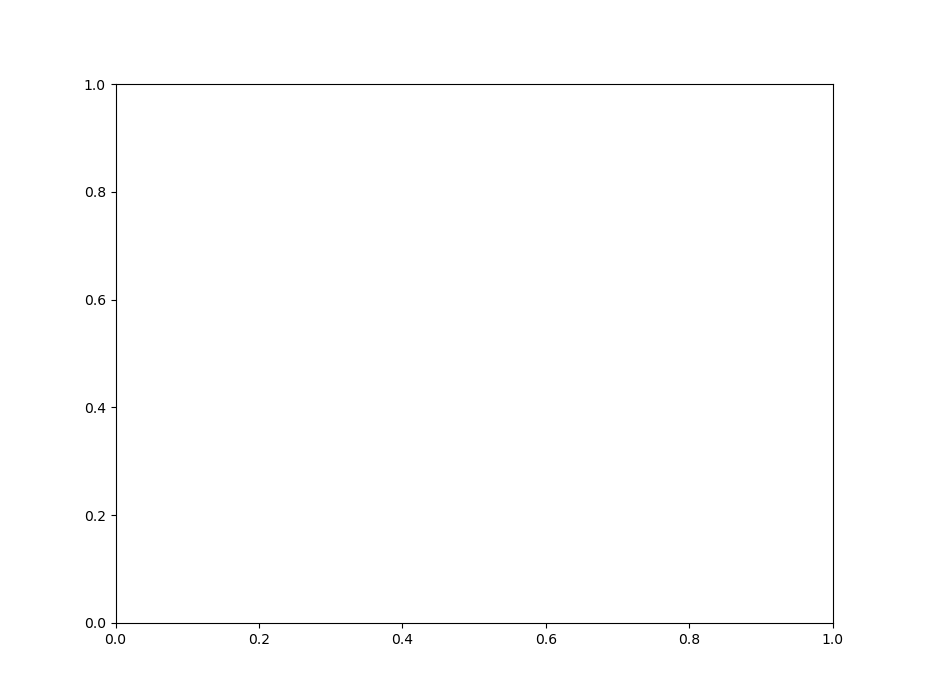

Checking for edge vars
edge dimension: mesh2d_nEdges


NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

In [6]:
nbviz.NBViz(datasets=[map_ds])